Progress Report 1
----

**Team Members**

Yaqian Cheng, Department of Statistical Science

Mengrun Li, Department of Statistical Science

**Github repository**

<https://github.com/cici7941/Sta_663_Statistical_Computation_Final_Project>

**Choice of paper** 

*Scalable K-Means++*

**Abstract**

*K-means* is one of the most popular clustering methods. A good initialization of *k-means* is essential for obtaining the global optimal solution and efficiency. However, there are two main obstacles with traditional *k-means* method. One is theoretical inefficiency and the other one is that its final solution is locally optimal. A better algorithm, *k-means++* addresses the second problem with an improved initialization procedure of the cluster centers. But this *k-means++* initialization is not parallelizable, because the selection for the *i*th center depends on the previous *i-1* centers [1]. Therefore, *k-means||*, a parallelizable version of *k-means++*, has been raised, which can both improve the final solution and run faster. In this report, we implemented the algorithm in the paper "Scalable K-Means++" in Python, compared the clustering cost and runtime between *k-means*, *k-means++* and *k-means||*, performed tests for main functions, profiled the performance of the algorithm and identified bottlenecks, and performed optimization using Cython. We then apply *k-means||* to a massive dataset to evaluate its performance.

**Outline**

1. Introduction
2. Algorithm  
    2.1 K-Means  
    2.2 K-Means++  
    2.3 K-Means||  
3. Code Testing
4. Profiling and Optimization
5. Application and Comparison

In [66]:
import scipy.linalg as la
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [67]:
# helper functions
def euc_dist(x, y):
    return la.norm(x-y)

def centroid(X):
    return X.mean(0)
    
def d(x, Y):
    minDist = float("inf")
    for yi in Y:
        dist = euc_dist(x, yi)
        if(dist < minDist):
            minDist = dist
    return minDist

def cost(Y, C):
    cost = 0
    for yi in Y:
        cost += d(yi, C)**2
    return cost

**Algorithm 1** *k-means++(k)* initialization 
1. $C$ $\leftarrow$ sample a point uniformly at random from $X$  
2. **while** |$C$| < $k$ **do**
3. $\,\,$ Sample $x$ \in $X$ with probability $\frac{d^2(x,C}{\psi_X(C)}$
4. $\,\,$ $C$ $\leftarrow$ $C$ $\cup$ $\{x\}$
5. **end while**

In [70]:
# K-Means++
def kmeansPlus(data, k):
    idx = np.random.choice(data.shape[0], 1)
    C = data[idx, :]
    while(C.shape[0] < k):
        prob = [d(xi,C)**2/cost(data,C) for xi in data]
        new = data[np.random.choice(data.shape[0], size=1, p=prob),:]
        if(new.tolist() not in C.tolist()):
            C = np.r_[C, new]
    return C

**Initialization algorithm: k-means||**  
*k-means||* uses an oversampling factor *l* = $\Omega$(k), which is unlike *k-means++*. Intuitively, *l* should be thought of as $\Theta$(k). This initialization algorithm picks an initial center uniformly from the dataset and computes $\psi$, here is initial cost of the clustering of this selection. Then do log$\psi$ iterations and in each iteration, it samples each x with probability *l*$d^2(x,C)/\psi_X(C)$ given current set C of centers. If the point is sampled, it will be added to C and the quantity $\phi_X(C)$ updated and interation continued. The expected number of points chosen in each iteration is l. Since there is oversampling factor, thus the number of points in C will be more than k. To reduce the number of centers, weight each point in C by the number of points in X whose distance to this point is shorter than it of any other point in C. And then recluster the weighted points to obtain k centers.

**Algorithm 2** *k-means||(k,l)* initialization  
1. $C$ $\leftarrow$ sample a point uniformly at random from $X$  
2. $\psi$ $\leftarrow$ $\phi_X(C)$  
3. **for** O(log$\psi$) times **do**  
      $\,\,$ $C'$ $\leftarrow$ sample each point $x \in X$ independently with probability $p_x = \frac{l*d^2(x,C)}{\phi_X(C)}$  
      $\,\,$ $C$ $\leftarrow$ $C$ $\cup$ $C'$  
   **end for**  
4. For x $\in$ $C$, set $w_x$ to be the number of points in X closer to x than any other point in C  
5. Recluster the weighted points in C into k clusters

In [31]:
# K-Means||
X_ori = np.random.normal(10,1,(100,10))
X = X_ori
k = 3
l = 2
##step1
##Sample a point uniformly at random from X
idx1 = np.random.choice(X_ori.shape[0],1,replace = False)
C = X[idx1,:]
print(idx1)
print("first centroid:",C)
##step2
##initial cost
gamma1 = cost(X,C)
print("initial cost:",gamma1)
##remove first centroid
X

[46]
first centroid: [[ 10.79909448  10.14057772   8.6558291   10.73591553  10.55064844
   10.03253223   9.0309344   11.53485582  10.84308318   9.78279535]]
initial cost: 1748.3750717407577


array([[ 10.15876896,   9.16720838,   9.81608237,   9.68606969,
         11.2995769 ,   9.09091263,   8.62405617,  10.67532251,
          9.17159805,   9.85463173],
       [  9.43699612,   9.5098993 ,  11.20212905,  10.17465234,
          8.40465522,   8.73501019,  10.02679979,  10.08320797,
         10.04758127,  10.24809014],
       [  9.56684777,   9.97498987,  10.76137426,  12.48006348,
          8.74944357,   9.11062182,  10.32575594,   9.01203817,
         10.01467881,  10.65350152],
       [ 10.01981865,   9.71955771,  11.36139595,   9.74244924,
          8.81263511,  10.77599372,  11.38588929,   9.60385264,
          7.94365299,  10.22532913],
       [  9.95580178,  10.07844155,   8.3552859 ,   9.26459526,
         11.23667503,  11.31291723,  10.09283993,  10.14216731,
         10.47461499,   8.60685015],
       [ 10.13248116,   8.74742022,  10.84051658,  11.94563698,
         12.22094913,  10.59801905,  10.16129053,  11.24704648,
         11.17136932,   8.67466375],
       [ 1

In [33]:
##step3-6
for i in range(int(round(np.log(gamma1)))):
    Ct = []
    idx = []
    gamma = cost(X,C)
    if(gamma == 0):
        break
    prob = [l*d(x,C)**2/gamma for x in X]
    #new = data[np.random.choice(X.shape[0], size=1, p=prob),:]
    for j in range(len(X)):
        if(prob[j] > 1):
            point = 1
        else:
            point = np.random.binomial(1,prob[j],size = 1)
        if point == 1 and (X[j,:].tolist() not in C.tolist()):
           Ct.append(X[j,:])
           idx.append(j)
    C = np.concatenate((C,np.array(Ct).reshape(len(Ct),C.shape[1])),axis = 0)
C

array([[ 10.79909448,  10.14057772,   8.6558291 ,  10.73591553,
         10.55064844,  10.03253223,   9.0309344 ,  11.53485582,
         10.84308318,   9.78279535],
       [  9.17432054,   8.97706888,   8.75452869,   9.20339501,
          9.9499869 ,   9.71437037,  11.70891839,  10.1979043 ,
          7.95296994,  12.31680225],
       [ 10.03659843,   9.27747812,  11.49176116,   8.55036244,
          9.84645322,   8.74627001,   7.58726261,   9.4241029 ,
         10.38066584,  10.26209273],
       [ 11.43142874,   9.16207322,   9.4130358 ,   8.77515302,
          9.04281857,  10.98795931,  10.95831622,  10.02403055,
         10.22070241,  11.07795982],
       [ 12.00850068,  11.02733338,   9.63375672,  10.3763001 ,
         10.72512112,   8.94276588,  10.88895065,   7.92520161,
         11.10171166,   9.21186486],
       [  8.84973277,  11.00336931,  10.52651138,   8.75852166,
         10.97717135,   9.96763971,   9.28476432,  10.31367156,
          9.75445962,  10.90071619],
       [  

In [34]:
##step7
w = []
for c in C:
    distxc = [euc_dist(x,c) for x in X]
    distc = [euc_dist(y,c) for y in C]
    distc.remove(0)
    count = 0
    for p in distxc:
        if p < min(distc):
           count += 1
    w.append(count)
w

[47, 9, 11, 37, 39, 32, 6]

In [35]:
##step8
w_prob = w/np.sum(w)
w_prob
centroid = np.random.choice(range(C.shape[0]),k,p = w_prob,replace = False)
centroid

array([3, 0, 4])

In [87]:
def weight(X,C):
    w = []
    for c in C:
        distxc = [euc_dist(x,c) for x in X]
        distc = [euc_dist(y,c) for y in C]
        distc.remove(0)
        count = 0
        for p in distxc:
           if p < min(distc):
               count += 1
        w.append(count)
    return w

In [86]:
##k-means||
def kmeansparallel(X_ori,k,l):
    X = X_ori
    ##Sample a point uniformly at random from X
    idx1 = np.random.choice(X_ori.shape[0],1,replace = False)
    C = X[idx1,:]
    ##remove first centroid
    X = np.delete(X, idx1, axis=0)
    for i in range(int(round(np.log(cost(X,C))))):
        Ct = []
        idx = []
        if(cost(X,C) == 0):
            break
        prob = [l*d(x,C)**2/cost(X,C) for x in X]
        for j in range(len(X)):
            if(prob[j] > 1):
                point = 1
            else:
                point = np.random.binomial(1,prob[j],size = 1)
            if point == 1:
               Ct.append(X[j,:])
               idx.append(j)
        X = np.delete(X, idx, axis = 0)
        C = np.concatenate((C,np.array(Ct).reshape(len(Ct),C.shape[1])),axis = 0)
    ##step8
    w = weight(X,C)
    w_prob = w/np.sum(w)
    centroid = np.random.choice(range(C.shape[0]),k,p = w_prob,replace = False)
    return C[centroid]

In [41]:
kmeansparallel(X_ori,k,l)

array([[  9.15970886,   8.65464043,   8.65657794,  10.01684392,
          8.62356909,  10.76026042,  10.10006833,   8.62627829,
          9.31459475,   9.09344404],
       [ 10.36012222,   8.58261338,  10.78272249,   8.82507984,
         11.25047488,  10.53441672,   9.74116923,   9.38442697,
          8.78149708,   9.62761915],
       [  9.90569089,  10.88023801,  11.2514743 ,   9.12080581,
          9.81239551,  11.05391231,   7.81351537,  10.89670725,
          9.57022762,   9.94424519]])

### Simulating Data

In [77]:
n = 100
mu1 = np.array([2, 6])
cov1 = np.array([[2, 0.5], [0.5, 2]])
subset1 = np.random.multivariate_normal(mu1, cov1, n)
subset1 = np.c_[subset1,np.ones(n)]

mu2 = np.array([5, 2])
cov2 = np.array([[2, 0.5], [0.5, 2]])
subset2 = np.random.multivariate_normal(mu2, cov2, n)
subset2 = np.c_[subset2,np.ones(n)+1]

mu3 = np.array([12, 5])
cov3 = np.array([[2, 1], [1, 2]])
subset3 = np.random.multivariate_normal(mu3, cov3, n)
subset3 = np.c_[subset3,np.ones(n)+2]

data = np.r_[subset1, subset2, subset3]
np.random.shuffle(data)

In [17]:
KMeans?

In [79]:
%%time
init = kmeansPlus(data[:,0:2], 3)

CPU times: user 4.26 s, sys: 31.8 ms, total: 4.29 s
Wall time: 4.33 s


In [91]:
%%time
init = kmeansparallel(data[:,0:2], 3, 2)

CPU times: user 2min 25s, sys: 888 ms, total: 2min 26s
Wall time: 2min 28s


In [82]:
y_pred_kmeans = KMeans(n_clusters=3,init = init,n_init=1).fit_predict(data[:,0:2])

In [92]:
y_pred_kmeans = KMeans(n_clusters=3,init = "random").fit_predict(data[:,0:2])
y_pred_kmeans_plus = KMeans(n_clusters=3,init = "k-means++").fit_predict(data[:,0:2])
y_pred_kmeans_plus_scalable = KMeans(n_clusters=3,init = init,n_init=1).fit_predict(data[:,0:2])

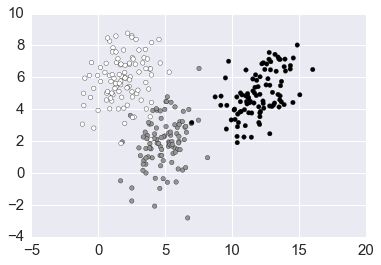

In [84]:
plt.scatter(data[:,0], data[:,1], c=data[:,2])

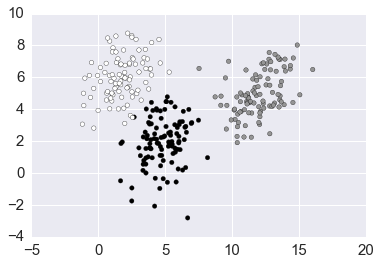

In [83]:
plt.scatter(data[:,0], data[:,1], c=y_pred_kmeans);

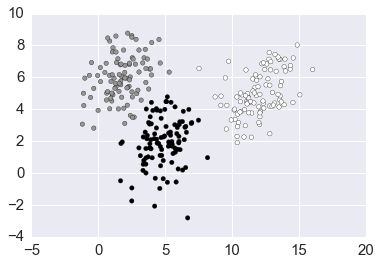

In [94]:
plt.scatter(data[:,0], data[:,1], c=y_pred_kmeans_plus);

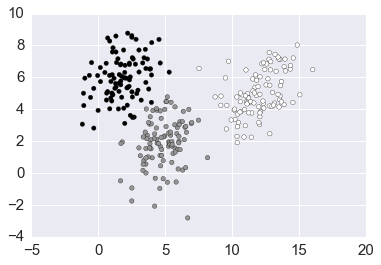

In [93]:
plt.scatter(data[:,0], data[:,1], c=y_pred_kmeans_plus_scalable);